In [2]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries

/home/barrel/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [32]:
import time
import warnings
import pandas as pd
import numpy as np
from numpy import newaxis
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import TensorBoard 
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers import Merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping




warnings.filterwarnings("ignore")

In [4]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [46]:
def load_data(filename, seq_len, normalise_window):
    f=pd.read_csv(filename, delimiter = '\t')
    data=np.array(f)
    data=data.astype('float')
    data_normalize = preprocessing.normalize(data)
    data_stand = preprocessing.scale(data_normalize)
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data_stand) - sequence_length):
        result.append(data_stand[index: index + sequence_length])
    
    
    result = np.array(result)

    row = round(0.9 * result.shape[0])
    
    train = result[:int(row), :]
    np.random.shuffle(train)
    Y = train[:,0]
    X = train[:,1:]
    if normalise_window:
        r = np.array(Y)
        normalised_data = (r-r.mean())/(r.max()-r.min())
        Y = np.array(normalised_data)
    
    x_train = X[:, :-1]
    y_train = Y[:, -16]
    cY = result[:,0]
    cX = result[:,1:]
    x_test = cX[int(row):, :-1]
    y_test = cY[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_train.shape[2]))  

    return [x_train, y_train, x_test, y_test]

In [6]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print "Compilation Time : ", time.time() - start
    return model

In [15]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [17]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print 'yo'
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        padding = np.array(padding)
        padding = padding.astype('float')
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [47]:
#Step 1 Load Data
X_train, y_train, X_test, y_test = load_data('msft2.csv', 50, False)

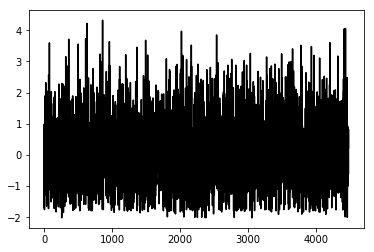

In [49]:
plt.plot(y_train, color='black', label = 'Train data')
plt.show()

In [50]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=16,
    output_dim=800,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    1600,
    return_sequences=False))
model.add(Dropout(0.2))
model.add(LeakyReLU())

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))


start = time.time()
model.compile(loss='mse', optimizer='rmsprop',)
print 'compilation time : ', time.time() - start

compilation time :  0.0133328437805


In [51]:
#Step 3 Train the model
tensorboard=TensorBoard(log_dir='./logs3', write_graph=True)
history = model.fit(
                    X_train,
                    y_train,
                    batch_size=512,
                    nb_epoch=2,
                    validation_split=0.05,
                    callbacks=[tensorboard])


Train on 4253 samples, validate on 224 samples
Epoch 1/2
4253/4253 [==============================] - 272s 64ms/step - loss: 20.1616 - val_loss: 1.1120
Epoch 2/2
4253/4253 [==============================] - 248s 58ms/step - loss: 0.8339 - val_loss: 0.7868


NameError: name 'FROM' is not defined

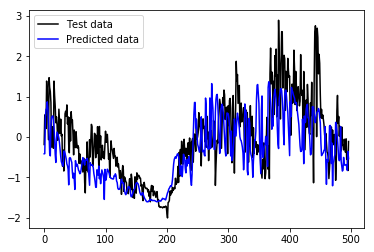

In [52]:
predicted = model.predict(X_test)

plt.plot(y_test, color='black', label = 'Test data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted from point %d to point %d of test set' % (FROM, TO))
plt.show()

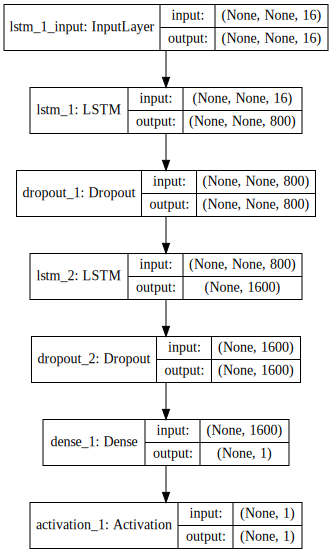

In [22]:

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

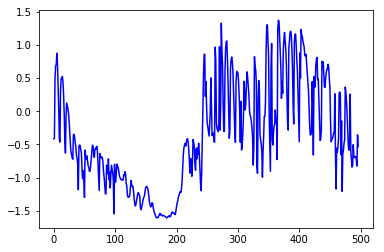

In [53]:
#Step 4 - Plot the predictions!
predictions = predict_point_by_point(model, X_test)
plt.plot(predictions, color='blue', label = 'Predicted data')
#plt.legend(loc='best')
#plt.title('Actual and predicted from point %d to point %d of test set' % (FROM, TO))
plt.show()
#plot_results_multiple(predictions, y_test, 50)